In [1]:
import os
import ast
import urllib2
import urllib
from cStringIO import StringIO
import getzips
import json
import numpy as np
import shapely
import matplotlib.pyplot as pl
import geopandas as gpd
import pandas as pd
%matplotlib inline

In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [3]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ Queries a url with an sql compatible search
    Code taken from Fbb55
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

### Get Shapefile with NYC ZipCodes¶

In [4]:
facilityQuery = '''SELECT count(cartodb_id), zipcodes 
                  FROM NYCAsthmasDismissals 
                  GROUP BY zipcodes
                  '''

facilityStream = queryCartoDB(facilityQuery, format='JSON')

facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.columns = ['Counts','ZIPCODE']
print facilities.shape
facilities.head()

(29, 2)


,Counts,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [5]:
getzips.getzips()

Downloading
Unzipped
Folder with required files in PUIdata, you can continue



### Work on Shapefile

In [20]:
zips = gpd.read_file(os.getenv("PUIDATA") + "/" + "ZIP_CODE_040114.shp")

In [21]:
zips.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [7]:
zips.columns

Index([      u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
       u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
            u'STATE',    u'ST_FIPS',        u'URL',    u'ZIPCODE',
         u'geometry'],
      dtype='object')

In [8]:
zips.shape

(263, 13)

In [9]:
zips.to_crs(epsg=2263, inplace=True) ###NAD83 New York Long Island Format

In [11]:
#Finding centroiod of the shapefile
zips.loc[:,'center'] = zips.loc[:,'geometry'].centroid

In [12]:
zips.drop([u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
           u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
           u'STATE',    u'ST_FIPS',        u'URL', u'geometry'], 
          axis = 1, inplace = True)

In [13]:
zips.ZIPCODE = zips.ZIPCODE.astype('int64')
zips.head()

,ZIPCODE,center
0,11436,POINT (1040696.262135346 185580.2219261284)
1,11213,POINT (1001912.871996465 183803.1131541364)
2,11212,POINT (1008365.375095716 180768.9448689773)
3,11225,POINT (997023.1926918954 180870.3533321856)
4,11218,POINT (990785.2911208547 173656.0483912209)


## Merge zipcode & Dismissal records¶

In [15]:
#Merge data
zips_facility = pd.merge(facilities, zips, how='inner', on='ZIPCODE')
zips_facility.head()

,Counts,ZIPCODE,center
0,1699,10461,POINT (1028292.72437689 247902.4282908511)
1,405,11373,POINT (1017941.215480482 208485.1046782668)
2,1698,10451,POINT (1005358.961284299 238316.0675282735)
3,220,11691,POINT (1050360.772370897 158235.4624442375)
4,246,11375,POINT (1026858.206454872 201880.2234938797)


In [16]:
krigdata = np.zeros((len(zips_facility),3))

In [17]:
for i in xrange(len(krigdata)):
    krigdata[i][0] = zips_facility.center[i].coords[0][0]
    krigdata[i][1] = zips_facility.center[i].coords[0][1]
    krigdata[i][2] = zips_facility.Counts[i]

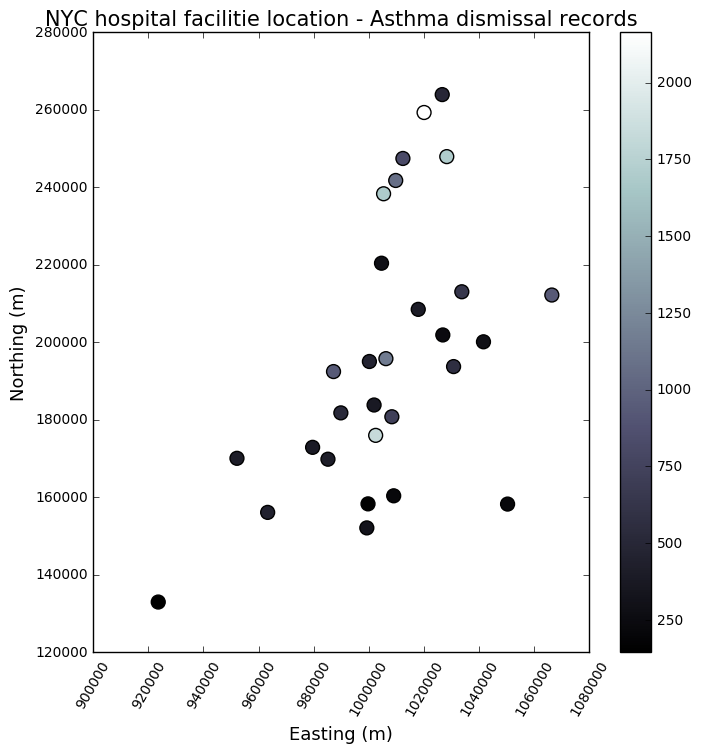

In [18]:
pl.figure(figsize=(8,8))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=13)
pl.xticks(rotation = 60)
pl.ylabel("Northing (m)", fontsize=13)
pl.title('NYC hospital facilitie location - Asthma dismissal records', fontsize=15)
pl.colorbar()

### Figure 1: The plot above shows location of NYC Hospitals on a northing vs. easting cordinate space and the color density shows Asthma Dismissal counts

In [ ]:
#@Review: 
#Missing semi-variogram and no commetns on the plots